# Analyse correlations in alignment of reads to human and arabidopsis

This notebook performs an analysis of a pair of full BAM files, one aligned to human genome and one to Arabidopsis.

It is looking for insert size correlations, specifically the nature of small inserts.

See also the subproject `small-fragments` for a detailed look at the read structure of small fragments.

* Run the bash script before using this notebook.

## Supporting code

In [1]:
import pysam
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sample = "NEB-100ng-1"
tags = ['arabidopsis', 'human']

In [3]:
def next_valid_hq_read(it):
    for r in it:
        if r.is_read1 and r.is_proper_pair and r.mapping_quality >= 20 and not r.is_secondary:
            return r
    return None
def next_valid_any_read(it):
    for r in it:
        if r.is_read1 and r.is_proper_pair and not r.is_secondary:
            return r
    return None

In [4]:
bams = [pysam.AlignmentFile(f"data/{sample}-{tag}-qsort.bam") for tag in tags]
iters = [bam.fetch(until_eof=True) for bam in bams]
current_read = [None, next_valid_hq_read(iters[1])]

# The list position acts as an index into arrays iters, current_read, etc.
# It allows to swap around the files and all corresponding values.

# Index into the other arrays: Determines which file is ahead in terms of query
# names, and which one is behind.
behind_file = 0
ahead_file = 1
# All other arrays stay fixed and are referenced through the position array.

MAX_LEN = 1000
size_corr = np.zeros((MAX_LEN, MAX_LEN))
unique = [0, 0]
both = 0

SMALL_FRAG_THRESH = 35
SMALL_FRAG_THRESH2 = 30

unique_small = [0, 0]
mapped_both_and_small = [0, 0]
unique_small2 = [0, 0]
mapped_both_and_small2 = [0, 0]

counter = 0

while current_read[1]:
    current_read[behind_file] = next_valid_hq_read(iters[behind_file])
    if not current_read[behind_file]:
        break
    elif current_read[behind_file].query_name > current_read[ahead_file].query_name:
        # We found a greater one in the current iterator (which was behind before).
        # Mark the read with qname less, in the "ahead" file, as unique to that file.
        unique[ahead_file] += 1
        if abs(current_read[ahead_file].tlen) < SMALL_FRAG_THRESH:
            unique_small[ahead_file] += 1
        if abs(current_read[ahead_file].tlen) < SMALL_FRAG_THRESH2:
            unique_small2[ahead_file] += 1
        # Then swap the order.
        ahead_file, behind_file = behind_file, ahead_file
    elif current_read[0].query_name == current_read[1].query_name:
        tlens = [min(999, abs(current_read[i].tlen)) for i in (0,1)]
        size_corr[tlens[0], tlens[1]] += 1
        #size_corr[tlens[1], tlens[0]] += 1
        both += 1
        for i, t in zip([0,1], tlens):
            if t < SMALL_FRAG_THRESH:
                mapped_both_and_small[i] += 1
            if t < SMALL_FRAG_THRESH2:
                mapped_both_and_small2[i] += 1
        current_read[ahead_file] = next_valid_hq_read(iters[ahead_file])
    else:
        # Our current iterator is still behind. The read we just processed was unique to our file.
        unique[behind_file] += 1
        if abs(current_read[behind_file].tlen) < SMALL_FRAG_THRESH:
            unique_small[behind_file] += 1
        if abs(current_read[behind_file].tlen) < SMALL_FRAG_THRESH2:
            unique_small2[behind_file] += 1
    counter += 1
    if counter == 5e6:
        print("Processed", counter, "raw reads")
        break

Processed 5000000 raw reads


In [5]:
c=plt.rcParams['axes.prop_cycle'].by_key()['color']

## Overall read mapping correlations

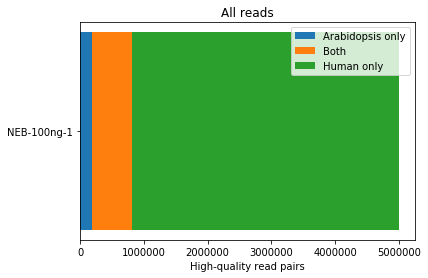

In [6]:
plt.barh([sample], [unique[0]], color=c[0], label="Arabidopsis only")
plt.barh([sample], [both], left=[unique[0]], color=c[1], label="Both")
plt.barh([sample], [unique[1]], left=[unique[0]+both], color=c[2], label="Human only")
plt.xlabel("High-quality read pairs")
plt.title("All reads")
plt.legend()

In [7]:
def rebin(squareHist, factor_row, factor_col):
    (nx0, ny0) = squareHist.shape
    return sum(
        squareHist[i::factor_row, j::factor_col]
        for i in range(factor_row)
        for j in range(factor_col)
    )

## 1. Correlation of mapped lengths for all reads mapping to both genomes

Text(0.5, 1.0, 'Reads mapped to both genomes')

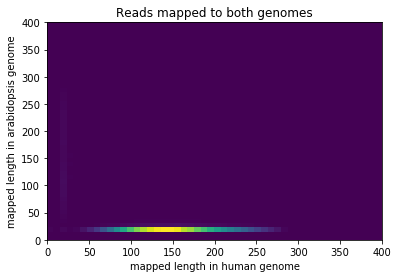

In [8]:
rebin_factor = 8
maxlen = 400
z = rebin(size_corr[:maxlen,:maxlen], rebin_factor, rebin_factor)
x = list(range(0, maxlen+1, rebin_factor))
y = list(range(0, maxlen+1, rebin_factor))
plt.pcolormesh(x, y, z)
plt.xlabel('mapped length in human genome')
plt.ylabel('mapped length in arabidopsis genome')
plt.title('Reads mapped to both genomes')

So many reads mapping with short length to arabidopsis -- we can't see much at all.

Text(0.5, 1.0, 'Range excludes shortest reads in arabidopsis genome')

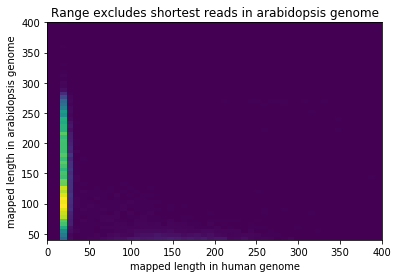

In [9]:
maxlen = 400
z = rebin(size_corr[40:maxlen,:maxlen], 6, 8)
x = list(range(0, maxlen+1, 8))
y = list(range(40, maxlen+1, 6))
plt.pcolormesh(x, y, z)

plt.xlabel('mapped length in human genome')
plt.ylabel('mapped length in arabidopsis genome')
plt.title('Range excludes shortest reads in arabidopsis genome')

In [10]:
print("Number of reads with >100 length in both genomes:",
     size_corr[100:,100:].sum() / 2, # Each read is counted twice, so divide by two
     "(",
      size_corr[100:,100:].sum() * 100.0 / size_corr.sum(),
      "%)")
print("Number of reads with <{} length in both genomes:".format(SMALL_FRAG_THRESH),
     size_corr[:SMALL_FRAG_THRESH,:SMALL_FRAG_THRESH].sum() / 2, # Each read is counted twice, so divide by two
     "(",
      size_corr[:SMALL_FRAG_THRESH,:SMALL_FRAG_THRESH].sum() * 100.0 / size_corr.sum(),
      "%)")

Number of reads with >100 length in both genomes: 313.5 ( 0.09865952080110901 %)
Number of reads with <35 length in both genomes: 817.0 ( 0.2571126905725871 %)


## 2. Study of short fragments and whether they map to the other genome

Just picking human as one example. Considering all small reads mapping to the human genome, how many are also mapping to arabidopsis genome (with any size).

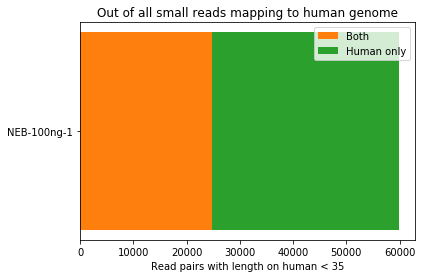

In [11]:
plt.barh([sample], [mapped_both_and_small[1]], color=c[1], label="Both")
plt.barh([sample], [unique_small[1]], left=[mapped_both_and_smallReducing[1]], color=c[2], label="Human only")
plt.xlabel("Read pairs with length on human < {}".format(SMALL_FRAG_THRESH))
plt.title("Out of all small reads mapping to human genome")
plt.legend()
plt.show()

Reducing the size threshold to check if the human-only reads are from a tail of the ordinary insert size distribution:

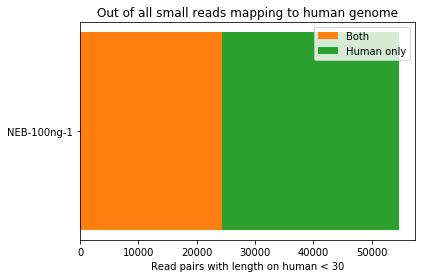

In [13]:
plt.barh([sample], [mapped_both_and_small2[1]], color=c[1], label="Both")
plt.barh([sample], [unique_small2[1]], left=[mapped_both_and_small2[1]], color=c[2], label="Human only")
plt.xlabel("Read pairs with length on human < {}".format(SMALL_FRAG_THRESH2))
plt.title("Out of all small reads mapping to human genome")
plt.legend()
plt.show()

Arabidopsis small reads

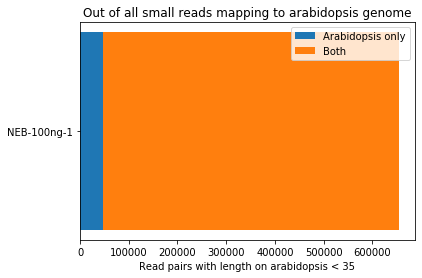

In [12]:
plt.barh([sample], [unique_small[0]], color=c[0], label="Arabidopsis only")
plt.barh([sample], [mapped_both_and_small[0]], left=[unique_small[0]], color=c[1], label="Both")
plt.xlabel("Read pairs with length on arabidopsis < {}".format(SMALL_FRAG_THRESH))
plt.title("Out of all small reads mapping to arabidopsis genome")
plt.legend()
plt.show()

### No mapping quality requirement

In [14]:
RA_SMALL_FRAG_THRESH = 35
def reanalyse_no_mq_cut():
    bams = [pysam.AlignmentFile(f"data/{sample}-{tag}-qsort.bam") for tag in tags]
    iters = [bam.fetch(until_eof=True) for bam in bams]
    current_read = [None, next_valid_any_read(iters[1])]
    behind_file = 0
    ahead_file = 1
    MAX_LEN = 1000
    unique_small = [0, 0]
    mapped_both_and_small = [0, 0]
    counter = 0
    while current_read[1]:
        current_read[behind_file] = next_valid_any_read(iters[behind_file])
        if not current_read[behind_file]:
            break
        elif current_read[behind_file].query_name > current_read[ahead_file].query_name:
            if abs(current_read[ahead_file].tlen) < RA_SMALL_FRAG_THRESH:
                unique_small[ahead_file] += 1
            ahead_file, behind_file = behind_file, ahead_file
        elif current_read[0].query_name == current_read[1].query_name:
            tlens = [min(999, abs(current_read[i].tlen)) for i in (0,1)]
            for i, t in zip([0,1], tlens):
                if t < RA_SMALL_FRAG_THRESH:
                    mapped_both_and_small[i] += 1
            current_read[ahead_file] = next_valid_hq_read(iters[ahead_file])
        else:
            if abs(current_read[behind_file].tlen) < RA_SMALL_FRAG_THRESH:
                unique_small[behind_file] += 1
        counter += 1
        if counter == 5e6:
            print("Processed", counter, "raw reads")
            break
    return unique_small, mapped_both_and_small

unique_small_nomq, mapped_both_and_small_nomq = reanalyse_no_mq_cut()

Processed 5000000 raw reads


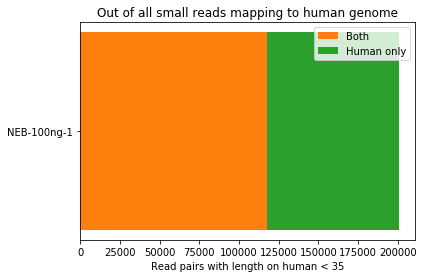

In [15]:
plt.barh([sample], [mapped_both_and_small_nomq[1]], color=c[1], label="Both")
plt.barh([sample], [unique_small_nomq[1]], left=[mapped_both_and_small_nomq[1]], color=c[2], label="Human only")
plt.xlabel("Read pairs with length on human < {}".format(RA_SMALL_FRAG_THRESH))
plt.title("Out of all small reads mapping to human genome")
plt.legend()
plt.show()

## Conclusion

We saw a sharp peak in the insert size distribution at sizes around 20-35 (very small!). The purpose of this notebook is the investigate if this peak has anything to do with DNA fragments from the other organism. Considering the peak at small inserts in humans, for example, is it caused by fragments from arabidopsis which are not actually so small, but get clipped because they don't fit well in the human genome.

More concretely, we want to check the following hypotheses:
1. Reads aligning to both genomes have short size in one and long (normal) size in the other
2. A significant fraction of all the reads aligning to one of the organisms with a short insert size also maps to the other organism, and are as described in (1).

Almost all of the reads that map to both genomes (in pairs, good quality, etc; see `get_read_pairs`) has a short insert size in one genome and a long insert size in the other. This confirms (1).

Out of all the reads with length < SMALL_FRAG_THRESH (35) mapped to the human genome, a large fraction also maps to the arabidopsis genome, however it is not the majority. The reverse effect is much more pronounced: by far most of the reads aligning with a short size to the arabidopsis genome also align to the human -- with a short size (as seen in the above plots).

Because there are vastly more human DNA fragments than Arabidopsis fragments in the libraries, the "human only" fraction of the small fragments (first plot in section (2)) can possibly be explained by the tail of the insert size distribution -- i.e. that they are genuine short fragments of human DNA. The plots in (2) reject this hypothesis: the fractions remain the same when reducing the threshold to SMALL_FRAG_THRESH2 (30). When looking at reads without requiring a mapping quality of 20, the majority of the reads are in both genomes, but a significant fraction is also only in human.


An observation worth noting, even if not relevant to the origin of the spike at short sizes, is that there are so few reads mapping to both genomes at the same time with long lengths. This shows that the short-read sequencing data studied here (i.e. 150 bases PE) is sufficient to distinguish between the two genomes for each read pair independently.